In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

matplotlib.rcParams['figure.figsize'] = (12, 8)

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
data = pd.read_csv('data/weatherAUS.csv')
data

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [4]:
int_columns = []
for col in data.select_dtypes(include=np.number).columns:
    test_data = data[col].dropna().sample(1000).values
    int_data = test_data.astype(int)
    if np.isclose(test_data, int_data).all():
        print(col, 'is integer')
        int_columns.append(col)
    

WindGustSpeed is integer
WindSpeed9am is integer
WindSpeed3pm is integer
Humidity9am is integer
Humidity3pm is integer
Cloud9am is integer
Cloud3pm is integer


In [5]:
for col in int_columns:
    print(col, data[col].unique()[:10])

WindGustSpeed [44. 46. 24. 41. 56. 50. 35. 80. 28. 30.]
WindSpeed9am [20.  4. 19. 11.  7.  6. 15. 17. 28. 24.]
WindSpeed3pm [24. 22. 26.  9. 20. 17. 28. 11.  6. 13.]
Humidity9am [71. 44. 38. 45. 82. 55. 49. 48. 42. 58.]
Humidity3pm [22. 25. 30. 16. 33. 23. 19.  9. 27. 91.]
Cloud9am [ 8. nan  7.  1.  0.  5.  4.  2.  6.  3.]
Cloud3pm [nan  2.  8.  7.  1.  5.  4.  6.  3.  0.]


1. tag nan values to 'Nan' column & drop nan labels

In [6]:
class PrepareData(BaseEstimator, TransformerMixin):
    def __init__(self, label_name):
        self.label_name = label_name
        
    def fit(self, X):
        self.X_ = X.copy()
        # tag missing values
        self.X_['Nan'] = self.X_.isna().any(axis=1)
        # remove missing labels
        self.X_.dropna(subset=[self.label_name], inplace=True)
        
        return self
    
    def transform(self, X):
        return self.X_
        

2. impute missing values with distribution of the column

In [7]:
from sklearn.impute import SimpleImputer

class DistributionalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, label_name):
        self.label_name = label_name
        self.label_data = None
        
    def _check_column_type(self, X):
        self.column_type = {}
        for col in self.null_cols:
            if col == self.label_name:
                continue
            if X[col].dtype == 'object':
                self.column_type[col] = 'cat'
            elif X[col].dtype == float:
                tmp = X[col].dropna().sample(1000)
                if np.isclose(tmp, tmp.astype(int)).all():
                    self.column_type[col] = 'int'
                else:
                    self.column_type[col] = 'float'
        
    def _make_dist(self, x0, x1, y0, y1):
        assert len(x0) == len(y0), 'x0 and y0 must be same length'
        assert len(x1) == len(y1), 'x1 and y1 must be same length'
        if not isinstance(y0, np.ndarray):
            y0 = np.array(y0)
        if not isinstance(y1, np.ndarray):
            y1 = np.array(y1)
            
        dist_info = {'x': {0: x0, 1: x1}, 'y': {0: y0.astype(float), 1: y1.astype(float)}}
        dist_info['y'][0] /= dist_info['y'][0].sum()
        dist_info['y'][1] /= dist_info['y'][1].sum()
        
        return dist_info
        
    def dist_cateogrical(self, X: pd.Series):
        assert X.dtype == 'object', 'X must be categorical'
        bars = sns.countplot(data=pd.DataFrame({'x': X, 'y': self.label_data}), x='x', hue='y')
        keys = [key.get_text() for key in bars.get_xticklabels()]
        yes_values, no_values = bars.patches[:len(keys)], bars.patches[len(keys):]
        assert len(yes_values) == len(no_values), 'Number of yes and no values must be equal'
        
        yes_values = np.array([value.get_height() for value in yes_values])
        no_values = np.array([value.get_height() for value in no_values])
        plt.close()
        
        return self._make_dist(keys, keys, yes_values, no_values)
    
    def dist_float(self, X: pd.Series):
        assert X.dtype == float, 'X must be float'
        kde = sns.kdeplot(data=pd.DataFrame({'x': X, 'y': self.label_data}), 
                          x='x', hue='y', gridsize=1000)
        yes_line, no_line = kde.lines
        yes_x, yes_y = yes_line.get_data()
        no_x, no_y = no_line.get_data()
        plt.close()
        
        return self._make_dist(no_x, yes_x, no_y, yes_y)
    
    def dist_int(self, X: pd.Series):
        # assert X.dtype == int, 'X must be int'
        kde = sns.kdeplot(data=pd.DataFrame({'x': X, 'y': self.label_data}),
                          x='x', hue='y', gridsize=500)
        yes_line, no_line = kde.lines
        yes_x, yes_y = yes_line.get_data()
        no_x, no_y = no_line.get_data()
        
        yes_x = np.round(yes_x).astype(int)
        no_x = np.round(no_x).astype(int)
        
        new_yes_y = []
        for u in np.unique(yes_x):
            new_yes_y.append(yes_y[yes_x == u].sum())
        
        new_no_y = []
        for u in np.unique(no_x):
            new_no_y.append(no_y[no_x == u].sum())

        plt.close()
        return self._make_dist(np.unique(no_x), np.unique(yes_x), new_no_y, new_yes_y)
    
    def fit(self, X):
        self.dist = {}
        self.label_data = X[self.label_name]
        self.null_cols = X.columns[X.isna().any()].tolist()
        self._check_column_type(X)
        
        for col in self.null_cols:
            if col == self.label_name:
                continue
            if self.column_type[col] == 'cat':
                dist_info = self.dist_cateogrical(X[col])
            elif self.column_type[col] == 'float':
                dist_info = self.dist_float(X[col])
            elif self.column_type[col] == 'int':
                dist_info = self.dist_int(X[col])
            else:
                raise ValueError('Column type not supported')
                
            self.dist[col] = dist_info
            
        return self
    
    def transform(self, X):
        X_ = X.copy()
        # null_cols = X_.columns[X_.isna().any()]
        for col in self.dist:
            no_idx = X_[X['Nan'] & (X_[self.label_name] == 'No')].index
            yes_idx = X_[X['Nan'] & (X_[self.label_name] == 'Yes')].index
            
            no_impute = np.random.choice(self.dist[col]['x'][0], size=len(no_idx), p=self.dist[col]['y'][0])
            yes_impute = np.random.choice(self.dist[col]['x'][1], size=len(yes_idx), p=self.dist[col]['y'][1])
            
            X_.loc[no_idx, col] = no_impute
            X_.loc[yes_idx, col] = yes_impute
        
        return X_
    
# dist_imputer = DistributionalImputer(label_name='RainTomorrow')
# data = dist_imputer.fit_transform(data)

3. preprocess categorical columns & date

In [30]:
from sklearn.preprocessing import OneHotEncoder

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, label_name, one_hot=False):
        self.label_name = label_name
        self.one_hot = one_hot
        self.encoder = None
        self.encoded_value = {}
        
    def _date_fit(self, X):
        date = pd.to_datetime(X['Date'])
        self.encoded_value['Year'] = date.dt.year
        self.encoded_value['Month'] = date.dt.month
        self.encoded_value['Day'] = date.dt.day
    
    def _direction_fit(self, X: pd.Series, col: str):
        directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
        self.encoded_value[col] = X[col].replace(directions, np.arange(len(directions)))
    
    def _bool_fit(self, X, col):
        self.encoded_value[col] = X[col].replace({'No': 0, 'Yes': 1})
    
    def _location_fit(self, X):
        locations_ordered = X.groupby('Location')[self.label_name].mean().sort_values(ascending=False).index
        if self.one_hot:
            self.encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
            self.encoder.fit(X.values.reshape(-1, 1))
        else:
            self.encoded_value['Location'] = X['Location'].replace(locations_ordered, np.arange(len(locations_ordered)))
    
    def fit(self, X):
        X[self.label_name] = X[self.label_name].replace({'No': 0, 'Yes': 1})
        for col in X.select_dtypes('object').columns[::-1]:
            if col == 'Date':
                self._date_fit(X)
            elif 'Dir' in col:
                self._direction_fit(X, col)
            elif 'Location' in col:
                self._location_fit(X)
            elif X[col].nunique() == 2:
                self._bool_fit(X, col)
            else:
                raise ValueError('Column type not supported')
        
        if self.one_hot:
            self.encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
            self.encoder.fit(X.drop(columns=self.label_name))
        
        return self
        
    def transform(self, X):
        X_ = X.copy()
        
        for k in self.encoded_value:
            X_[k] = self.encoded_value[k]
        
        if self.one_hot:
            X_ = pd.DataFrame(self.encoder.transform(X_), columns=self.encoder.get_feature_names())
            X_.index = X.index
            X_ = pd.concat([X_, X[self.label_name]], axis=1)
        
        return X_
    
# cat_encoder = CategoricalEncoder(label_name='RainTomorrow', one_hot=False)
# tmp = cat_encoder.fit_transform(data)

4. pipeline

In [ ]:
from sklearn.pipeline import Pipeline

preprocessor = Pipeline(['prepare_data': PrepareData(),
                         'dist_imputer': DistributionalImputer(label_name='RainTomorrow'),
                         'cat_encoder': CategoricalEncoder(label_name='RainTomorrow', one_hot=False)])

5. train test split

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

def train_test_split(data, test_size=0.2, label_name='RainTomorrow', random_state=None):
    non_null_idx = data[data['Nan']==False].index
    assert len(non_null_idx) >= len(data)*test_size, 'Not enough data to split'
    
    cv = StratifiedShuffleSplit(test_size=int(len(data) * test_size),
                                random_state=random_state)
    
    _, test_idx = next(cv.split(X=data.loc[non_null_idx], 
                                y=data.loc[non_null_idx, label_name]))
    
    train_idx = data.index.difference(test_idx)
    train = data.loc[train_idx].shuffle(random_state=random_state)
    test = data.loc[test_idx]
    
    X_train = train.drop(columns=label_name)
    y_train = train[label_name]
    X_test = test.drop(columns=label_name)
    y_test = test[label_name]
    
    return X_train, y_train, X_test, y_test

In [11]:
# original_data = data.copy()
data = original_data.copy()

In [12]:
prepare_data = PrepareData(label_name='RainTomorrow')
data = prepare_data.fit_transform(data)

In [13]:
data.isnull().any(axis=1).sum()

85773

In [14]:
data['Nan'].value_counts()

True     85773
False    56420
Name: Nan, dtype: int64

In [ ]:
dist_imputer = DistributionalImputer(label_name='RainTomorrow')
data = dist_imputer.fit_transform(data)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142193 entries, 0 to 145458
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        142193 non-null  float64
 3   MaxTemp        142193 non-null  float64
 4   Rainfall       142193 non-null  float64
 5   Evaporation    142193 non-null  float64
 6   Sunshine       142193 non-null  float64
 7   WindGustDir    142193 non-null  object 
 8   WindGustSpeed  142193 non-null  float64
 9   WindDir9am     142193 non-null  object 
 10  WindDir3pm     142193 non-null  object 
 11  WindSpeed9am   142193 non-null  float64
 12  WindSpeed3pm   142193 non-null  float64
 13  Humidity9am    142193 non-null  float64
 14  Humidity3pm    142193 non-null  float64
 15  Pressure9am    142193 non-null  float64
 16  Pressure3pm    142193 non-null  float64
 17  Cloud9am       142193 non-nul

/tmp/ipykernel_5583/4285349526.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.countplot(data=data[original_data.isnull().any(axis=1)], x='Cloud9am', hue='RainTomorrow', ax=ax)


<AxesSubplot:xlabel='Cloud9am', ylabel='count'>

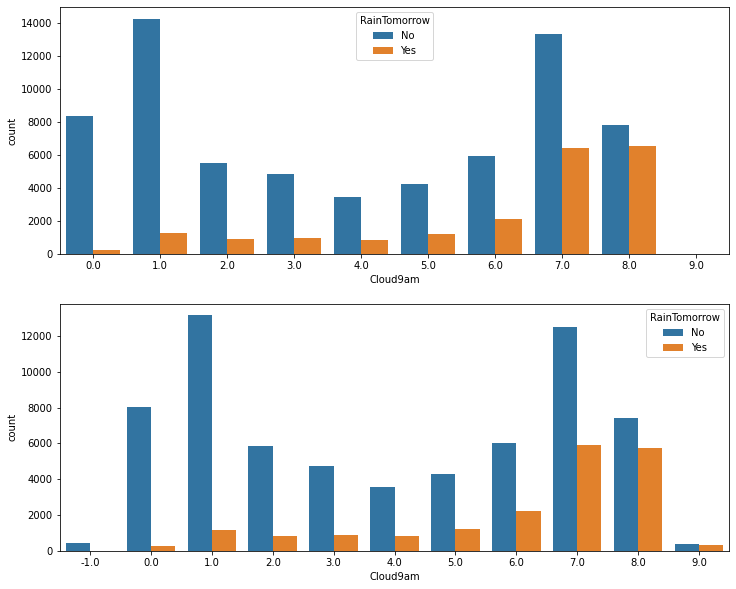

In [19]:
fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(211)
sns.countplot(data=original_data, x='Cloud9am', hue='RainTomorrow', ax=ax)
ax = fig.add_subplot(212)
sns.countplot(data=data[original_data.isnull().any(axis=1)], x='Cloud9am', hue='RainTomorrow', ax=ax)


/tmp/ipykernel_47924/3582940122.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.countplot(data=data[original_data.isnull().any(axis=1)], x=col, hue='RainTomorrow', ax=ax, order=directions)


<AxesSubplot:xlabel='WindGustDir', ylabel='count'>

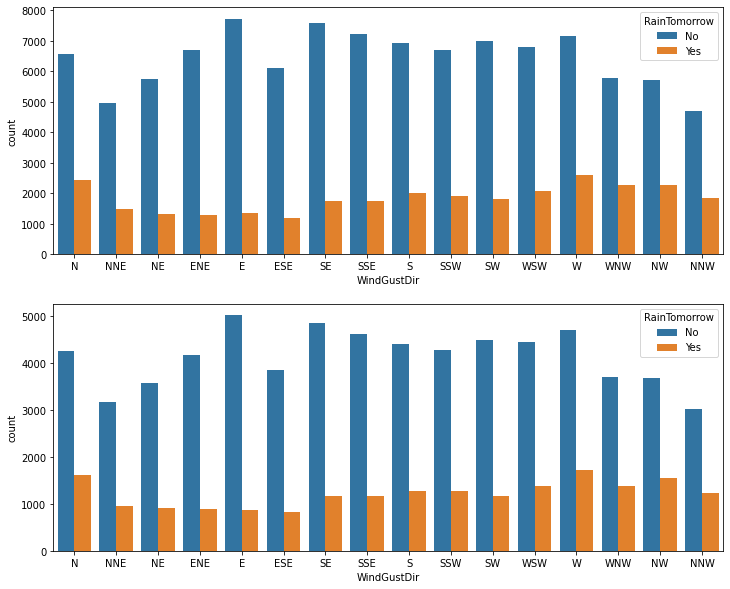

In [28]:
col = 'WindGustDir'
directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(211)
sns.countplot(data=original_data, x=col, hue='RainTomorrow', ax=ax, order=directions)

ax = fig.add_subplot(212)
sns.countplot(data=data[original_data.isnull().any(axis=1)], x=col, hue='RainTomorrow', ax=ax, order=directions)


/tmp/ipykernel_47924/2776169302.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.kdeplot(data=data[original_data.isnull().any(axis=1)], x=col, hue='RainTomorrow', ax=ax)


<AxesSubplot:xlabel='Sunshine', ylabel='Density'>

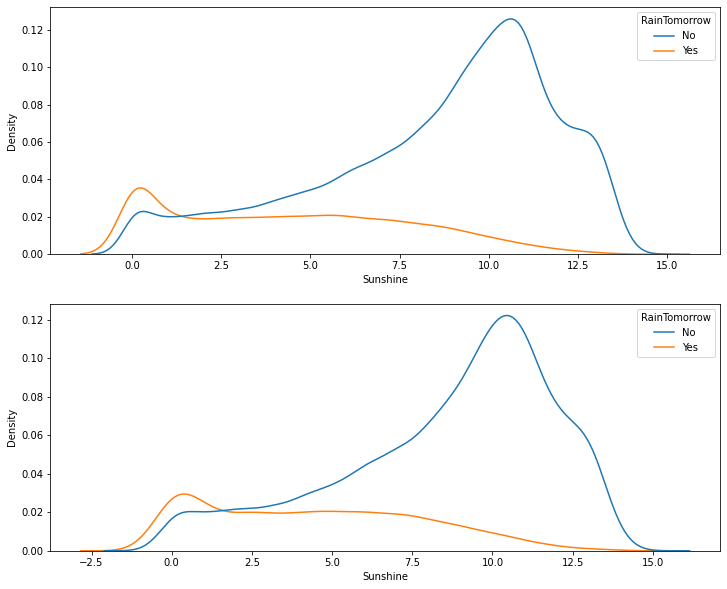

In [29]:
col = 'Sunshine'

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(211)
sns.kdeplot(data=original_data, x=col, hue='RainTomorrow', ax=ax)

ax = fig.add_subplot(212)
sns.kdeplot(data=data[original_data.isnull().any(axis=1)], x=col, hue='RainTomorrow', ax=ax)


In [31]:
cat_encoder = CategoricalEncoder(label_name='RainTomorrow', one_hot=False)
data = cat_encoder.fit_transform(data)